In [5]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split


In [15]:
path = "C:/Users/A/.cache/kagglehub/datasets/fedesoriano/electric-power-consumption/versions/1"
print("Path to dataset files:", path)

Path to dataset files: C:/Users/A/.cache/kagglehub/datasets/fedesoriano/electric-power-consumption/versions/1


In [13]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("fedesoriano/electric-power-consumption")

# Print the dataset path
print("Path to dataset files:", path)


Path to dataset files: C:\Users\A\.cache\kagglehub\datasets\fedesoriano\electric-power-consumption\versions\1


In [19]:
import os

dataset_path = "C:/Users/A/.cache/kagglehub/datasets/fedesoriano/electric-power-consumption/versions/1"
print("Files in dataset directory:", os.listdir(dataset_path))


Files in dataset directory: ['powerconsumption.csv']


In [21]:
df = pd.read_csv(f"{path}/powerconsumption.csv", sep=';', low_memory=False, na_values=['?'])
df.head()

,"Datetime,""Temperature"",""Humidity"",""WindSpeed"",""GeneralDiffuseFlows"",""DiffuseFlows"",""PowerConsumption_Zone1"",""PowerConsumption_Zone2"",""PowerConsumption_Zone3"""
0,"1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,340..."
1,"1/1/2017 0:10,6.414,74.5,0.083,0.07,0.085,2981..."
2,"1/1/2017 0:20,6.313,74.5,0.08,0.062,0.1,29128...."
3,"1/1/2017 0:30,6.121,75,0.083,0.091,0.096,28228..."
4,"1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,273..."


In [27]:
print(df.columns)


Index(['Datetime,"Temperature","Humidity","WindSpeed","GeneralDiffuseFlows","DiffuseFlows","PowerConsumption_Zone1","PowerConsumption_Zone2","PowerConsumption_Zone3"'], dtype='object')


In [53]:
df_raw = pd.read_csv(f"{path}/powerconsumption.csv", header=None)
print(df_raw.head())  # Check first few rows
df = pd.read_csv(f"{path}/powerconsumption.csv", sep=',', low_memory=False, na_values=['?'], header=0)
df.columns = df.columns.astype(str)

               0            1         2          3                    4  \
0       Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows   
1  1/1/2017 0:00        6.559      73.8      0.083                0.051   
2  1/1/2017 0:10        6.414      74.5      0.083                 0.07   
3  1/1/2017 0:20        6.313      74.5       0.08                0.062   
4  1/1/2017 0:30        6.121        75      0.083                0.091   

              5                       6                       7  \
0  DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2   
1         0.119              34055.6962             16128.87538   
2         0.085             29814.68354             19375.07599   
3           0.1             29128.10127             19006.68693   
4         0.096             28228.86076             18361.09422   

                        8  
0  PowerConsumption_Zone3  
1             20240.96386  
2             20131.08434  
3             19668.43373  
4     

In [59]:
# Load dataset into Pandas DataFrame
df = pd.read_csv(f"{path}/powerconsumption.csv", sep=',', low_memory=False, na_values=['?'], header=None)

df.columns = df.iloc[0]  # Set first row as column names
df = df[1:].reset_index(drop=True)  # Remove the first row from data
df.columns = df.columns.astype(str)  # Ensure column names are strings

In [63]:
### **Step 3: Data Preprocessing**

# Check column names
print("Dataset Columns:", df.columns)

# Rename the correct datetime column if needed
if 'Datetime' not in df.columns:
    for col in df.columns:
        if 'Datetime' in col:
            df.rename(columns={col: 'Datetime'}, inplace=True)
            break

# Convert Datetime column to datetime format if it exists
if 'Datetime' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
    df.set_index('Datetime', inplace=True)
else:
    print("Warning: No Datetime column found in dataset.")

# Convert numerical columns to float
df = df.apply(pd.to_numeric, errors='coerce')

# Handle missing values
df = df.ffill()

# Select only one feature for RNN (PowerConsumption_Zone1)
power_col = [col for col in df.columns if 'PowerConsumption_Zone1' in col]
if power_col:
    data = df[[power_col[0]]]
else:
    raise KeyError("PowerConsumption_Zone1 column not found in dataset.")

Dataset Columns: Index(['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2',
       'PowerConsumption_Zone3'],
      dtype='object', name=0)


In [65]:
### **Step 4: Data Normalization**

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

data_scaled = pd.DataFrame(data_scaled, columns=['PowerConsumption_Zone1'], index=data.index)

data_scaled.head()


,PowerConsumption_Zone1
Datetime,
2017-01-01 00:00:00,0.526251
2017-01-01 00:10:00,0.415545
2017-01-01 00:20:00,0.397623
2017-01-01 00:30:00,0.374149
2017-01-01 00:40:00,0.350834


In [69]:
### **Step 5: Prepare Data for RNN**

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 50  # Number of time steps
X, y = create_sequences(data_scaled.values, seq_length)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape input for RNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [71]:
### **Step 6: Build and Train the RNN Model**

model = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    SimpleRNN(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


C:\Users\A\anaconda3\envs\gpu-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1310/1310 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - loss: 0.0070 - val_loss: 8.4432e-04
Epoch 2/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 0.0015 - val_loss: 2.6128e-04
Epoch 3/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 0.0011 - val_loss: 3.3299e-04
Epoch 4/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 9.5539e-04 - val_loss: 1.7808e-04
Epoch 5/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 8.6775e-04 - val_loss: 2.3008e-04
Epoch 6/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 8.5296e-04 - val_loss: 5.4822e-04
Epoch 7/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 7.9784e-04 - val_loss: 2.6867e-04
Epoch 8/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 7.9532e-04 - val_loss: 5.3542e-04
Epoch 9/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 7.7535e-04 - val_loss: 6.6670e-04
Epoch 10/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 7.6509e-04 - val_loss: 0.0013
Epoch 11/20
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 22s

In [73]:
### **Step 7: Evaluate the Model**

loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")


328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015
Test Loss: 0.0012680647196248174


In [75]:
### **Step 8: Make Predictions**

y_pred = model.predict(X_test)


328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


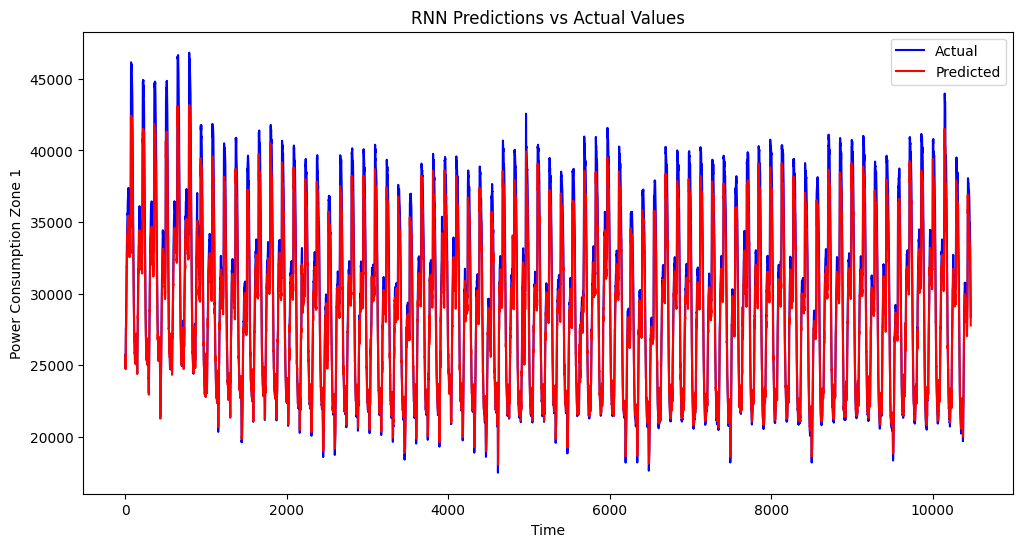

In [77]:
# Inverse transform the predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

### **Step 9: Visualize Predictions**

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual', color='blue')
plt.plot(y_pred_inv, label='Predicted', color='red')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Power Consumption Zone 1")
plt.title("RNN Predictions vs Actual Values")
plt.show()


In [79]:
# Select a sample from the dataset (e.g., last sequence from X_test)
sample_input = X_test[-1].reshape(1, seq_length, 1)

# Make a prediction
sample_prediction = model.predict(sample_input)

# Inverse transform the prediction
sample_prediction_inv = scaler.inverse_transform(sample_prediction.reshape(-1, 1))

print("Sample Predicted Power Consumption (Zone 1):", sample_prediction_inv[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Sample Predicted Power Consumption (Zone 1): 27768.107
